# UNSUPERVISED LEARNING

# LOAD DEPENDENCIES

In [1]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

# LOAD DATA

In [2]:
df_sample_submission = pd.read_csv('resources/sample_submission.csv')
df_movies = pd.read_csv('resources/movies.csv')
df_imdb = pd.read_csv('resources/imdb_data.csv')
df_genome_scores = pd.read_csv('resources/genome_scores.csv')
df_genome_tags = pd.read_csv('resources/genome_tags.csv')
df_train = pd.read_csv('resources/train.csv')
df_test = pd.read_csv('resources/test.csv')
df_tags = pd.read_csv('resources/tags.csv')
df_links = pd.read_csv('resources/links.csv')

In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [4]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [5]:
df_genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [6]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [7]:
df_movies.genres.describe()

count     62423
unique     1639
top       Drama
freq       9056
Name: genres, dtype: object

In [8]:
df_links.describe()

,movieId,imdbId,tmdbId
count,62423.000000,6.242300e+04,62316.000000
mean,122220.387646,1.456706e+06,155186.689999
std,63264.744844,2.098007e+06,153362.694700
min,1.000000,1.000000e+00,2.000000
25%,82146.500000,8.168650e+04,36768.750000
50%,138022.000000,3.258050e+05,86750.500000
75%,173222.000000,2.063724e+06,255255.250000
max,209171.000000,1.117094e+07,646282.000000


##DEAL WITH MOVIES FIRST

In [9]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
df_movies.genres.describe()

count     62423
unique     1639
top       Drama
freq       9056
Name: genres, dtype: object

In [11]:
df_movies.genres.mode()

0    Drama
dtype: object

In [12]:
df_movies['genres'].value_counts()[0:10]

Drama                   9056
Comedy                  5674
(no genres listed)      5062
Documentary             4731
Comedy|Drama            2386
Drama|Romance           2126
Horror                  1661
Comedy|Romance          1577
Comedy|Drama|Romance    1044
Drama|Thriller           933
Name: genres, dtype: int64

Check distribution of the different genres

<AxesSubplot:>

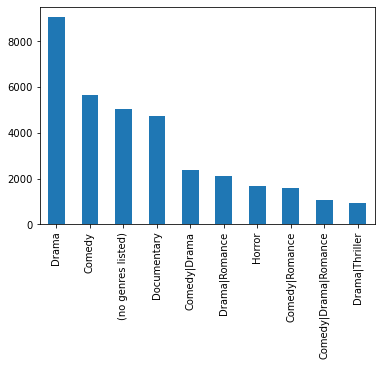

In [13]:
df_movies['genres'].value_counts()[:10].plot(kind='bar')
    

We are abe to visualise that Drama is the leading genre and drama|Thriller is the least most watched genre

In [14]:
###look st df_imdb

In [15]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [16]:
df_imdb['director'].value_counts()[0:10]

See full summary       28
Woody Allen            26
Luc Besson             26
Stephen King           24
William Shakespeare    19
Ki-duk Kim             17
Tyler Perry            15
Lars von Trier         15
Robert Rodriguez       14
Takeshi Kitano         14
Name: director, dtype: int64

<AxesSubplot:>

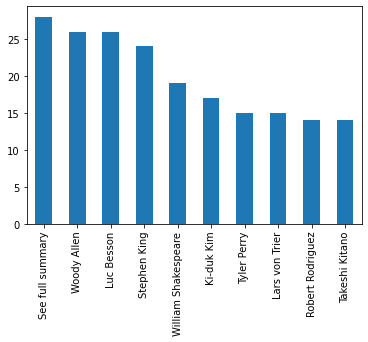

In [17]:
df_imdb['director'].value_counts()[:10].plot(kind='bar')

In [18]:
df_imdb['plot_keywords'].value_counts()

Documentary                                                   19
Action                                                        16
f rated                                                       16
Comedy                                                        12
stand up special|stand up comedy                               9
                                                              ..
purgatory|tattoo on back|sex scene|character name as title     1
kiss|arcade|copyright infringement|cyberpunk                   1
drugs|drug dealer|war on drugs|police raid                     1
artist|movie director|health problem|friendship                1
israel|friendship|desert|1960s                                 1
Name: plot_keywords, Length: 16008, dtype: int64

Plot keywords are words or phrases that describe motifs, themes, character types, or plot details
Visualise plot_keywords

<AxesSubplot:>

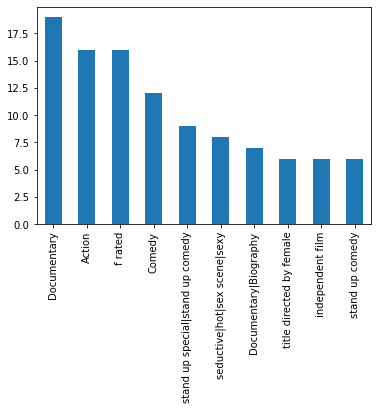

In [19]:
df_imdb['plot_keywords'].value_counts()[:10].plot(kind='bar')